This template notebook should serve as a guide for how to load and manipulate the dataset, and the different preprocessing methods you may choose to implement (you are welcome to try any others outside of what is provided here). This code should be treated as pseudo-code - and you may have to debug this code to get it working adequately.

In this notebook, we only access the labeled portion of the training dataset, and directly run/train/fit supervised methods. e.g., Multinomial Naive Bayes and Linear SGD classifiers (linear SGD [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html] implements regularized linear models with stochastic gradient descent, e.g., by choosing loss=‘log_loss’, you obtain a logistic regression classifier), on only this labeled portion of the training dataset. The performance values you get from running this experiment will serve as your baseline.

Once you have these baseline numbers for the configuration of preprocessing and supervised methods you choose (ideally at least 2 preprocessing methods and also at least 2 supervised methods), you can now begin working on Part 1: i.e. using unsupervised learning methods to automate adding labels to the unlabelled portion of the train dataset. The goal is to see if adding these newly labeled data examples to the train set will improve the baseline numbers you obtained (i.e. Part 2: running the supervised methods you chose for the baseline on the newly augmented dataset and reporting the performance on this augmented dataset).

Lastly, please note that there is a class imbalance in the train, test, and val sets. You will have to incorporate an approach to deal with this. 

In [ ]:
# e.g. if using google colab import drive, uncomment lines below
from google.colab import drive
drive.mount('/content/drive')

In [5]:
# import packages

import os
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression as sk_OLS
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier

import torch
import torch.nn.functional as F
import math

from sklearn.metrics import r2_score
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation

## Download the data

In [25]:
train_data = pd.read_csv("./data/train.csv")
val_data = pd.read_csv("./data/val.csv")
test_data = pd.read_csv("./data/test.csv")

In [26]:
# get all train data (labelled and unlabelled)
X_train    = train_data['Phrase']
y_train    = train_data['Sentiment']

index_of_2_to_remove = np.random.choice(np.arange(y_train.size)[y_train == 2], np.arange(y_train.size)[y_train == 2].size - 10000, replace=False)
index_of_2_to_remove.sort()
X_train = X_train.drop(index_of_2_to_remove)
y_train = y_train.drop(index_of_2_to_remove)
train_data = train_data.drop(index_of_2_to_remove)

# get only labelled train data
mask = (y_train != -100)
train_data_clean    = train_data[mask]
X_train_clean    = X_train[mask]
y_train_clean    = y_train[mask]

# get val data
X_val    = val_data['Phrase']
y_val    = val_data['Sentiment']

# get test data
X_test     = test_data['Phrase']

print(f"Train Data Shape: {X_train.shape}")
print(f"Cleaned Train Data Shape: {train_data_clean['Phrase'].shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Test Data Shape: {X_test.shape}")

print(" ")
print(f"Number of labels = 0 in train dataset as percentage: {((y_train == 0).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in train dataset as percentage: {((y_train == 1).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in train dataset as percentage: {((y_train == 2).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in train dataset as percentage: {((y_train == 3).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in train dataset as percentage: {((y_train == 4).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = -100 in train dataset as percentage: {((y_train == -100).sum() / (X_train.shape[0])) * 100:0.2f}%")

print(" ")
print(f"Number of labels = 0 in val dataset as percentage: {((y_val == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((y_val == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_val == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((y_val == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((y_val == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = -100 in val dataset as percentage: {((y_val == -100).sum() / (X_val.shape[0])) * 100:0.2f}%")

Train Data Shape: (96824,)
Cleaned Train Data Shape: (31279,)
Validation Data Shape: (23409,)
Test Data Shape: (23409,)
 
Number of labels = 0 in train dataset as percentage: 1.97%
Number of labels = 1 in train dataset as percentage: 7.79%
Number of labels = 2 in train dataset as percentage: 10.33%
Number of labels = 3 in train dataset as percentage: 9.54%
Number of labels = 4 in train dataset as percentage: 2.67%
Number of labels = -100 in train dataset as percentage: 67.69%
 
Number of labels = 0 in val dataset as percentage: 4.52%
Number of labels = 1 in val dataset as percentage: 17.47%
Number of labels = 2 in val dataset as percentage: 50.61%
Number of labels = 3 in val dataset as percentage: 21.33%
Number of labels = 4 in val dataset as percentage: 6.08%
Number of labels = -100 in val dataset as percentage: 0.00%


We observe that out of all the labelled data we have (train data), a lot of data points are assigned the label 2. This skew in our data is bound to cause inconsistencies in training down the line so we aim to keep only about 50% of the rows of label 2 (10000 are kept out of the total 22000 rows labelled 2)

# Define Preprocessing Helper Functions

In [29]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    #added substitutions

    #***********added substitutions***********
    # remove all the special characters
    texter = re.sub(r'\W', ' ', texter)
    # remove all single characters
    texter = re.sub(r'\s+[a-zA-Z]\s+', ' ', texter)
    # Remove single characters from the start
    texter = re.sub(r'\^[a-zA-Z]\s+', ' ', texter)
    # Remove numbers
    texter = re.sub(r'\d+', ' ', texter)
    # Converting to Lowercase
    texter = texter.lower()
    # Remove punctuation
    texter = re.sub(r'[^\w\s]', ' ', texter)
    # Remove parentheses
    texter = re.sub(r'\([^)]*\)', ' ', texter)
    # Remove single quotes
    texter = re.sub(r'\'', ' ', texter)
    # Substituting multiple spaces with single space
    texter = re.sub(r'\s+', ' ', texter, flags=re.I)

    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

def clean_dataset(dataset):
    for row in range(dataset.shape[0]):
        dataset[row,0] = clean(dataset[row,0])
    return dataset

def tokenize_lexicon(texts):
    return_texts = []
    for i in range(len(texts)):
        return_texts.append(nltk.word_tokenize(texts[i]))
        return_texts[i] = nltk.pos_tag(return_texts[i])
    return return_texts

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wn.ADJ
    elif pos_tag.startswith('V'):
        return wn.VERB
    elif pos_tag.startswith('N'):
        return wn.NOUN
    elif pos_tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

def lemmatize_texts(texts):
    return_texts = []
    lemmer = nltk.stem.WordNetLemmatizer()
    for i in range(len(texts)):
        return_texts.append([])
        for j in range(len(texts[i])):
                return_texts[i].append(lemmer.lemmatize(texts[i][j][0], pos=get_wordnet_pos(texts[i][j][1])))
    return return_texts

def stem_texts(texts):
    return_texts = []
    ps = PorterStemmer()
    for i in range(len(texts)):
        return_texts.append([])
        for j in range(len(texts[i])):
                return_texts[i].append(ps.stem(texts[i][j][0]))
    return return_texts


def backtostring(texts):
    return_texts = []
    for i in range(len(texts)):
        return_texts.append(" ".join(texts[i]))
    return return_texts

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laksh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laksh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laksh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Preprocess using Bag of Words

In [30]:
def pre_process(data):
    preproc_data = data.copy()
    preproc_data = preproc_data.str.lower()
    punctuation = string.punctuation
    mapping = str.maketrans("", "", punctuation)
    preproc_data = preproc_data.str.translate(mapping)
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    preproc_data = preproc_data.apply(lambda text: ' '.join([word for word in text.split() if word.lower() not in stop_words]))
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    preproc_data = preproc_data.apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in text.split()]))
    preproc_data = preproc_data.apply(lambda text: re.sub(r'@\w+', '', re.sub(r'http\S+|www\S+', '', text)))
    return preproc_data

# get the preprocessed data
X_train_preproc   = pre_process(X_train)
X_train_clean_preproc   = pre_process(X_train_clean)
X_val_preproc = pre_process(X_val)
X_test_preproc = pre_process(X_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laksh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laksh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laksh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laksh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laksh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laksh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_d

Bag of words model

In [31]:
combined_data = pd.concat([X_train_preproc, X_val_preproc, X_test_preproc])

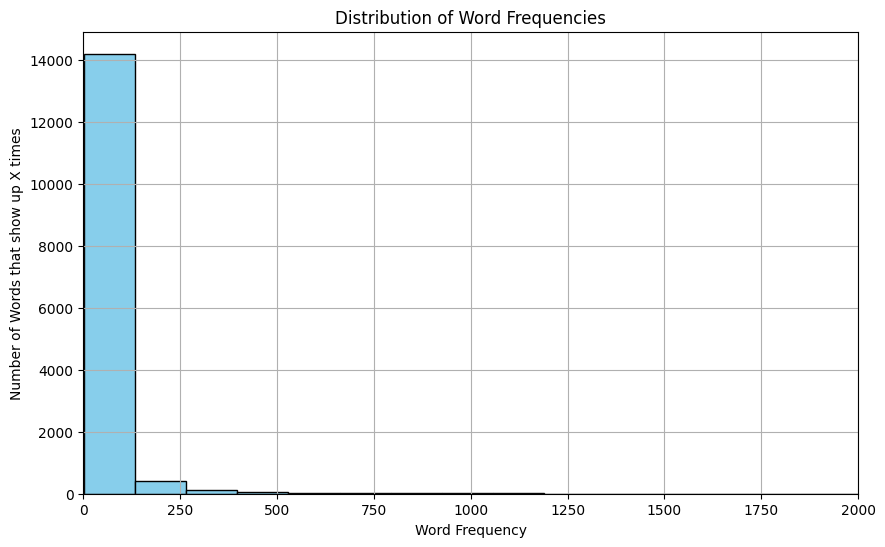

In [32]:
text_data = combined_data
words = ' '.join(text_data).split()
word_freq_dict = Counter(words)

word_frequencies = list(word_freq_dict.values())

plt.figure(figsize=(10, 6))
plt.hist(word_frequencies, bins=55, color='skyblue', edgecolor='black')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words that show up X times')
plt.title('Distribution of Word Frequencies')
plt.grid(True)
plt.xlim(0, 2000)
plt.show()

In [33]:
def bag_of_word(data,  threshold_M):
    vectorizer = CountVectorizer(binary=True, max_features= threshold_M)
    vectorizer.fit(combined_data)
    X = vectorizer.transform(data)
    featurized_data = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
    return featurized_data

# get the featurized data
X_train   = bag_of_word(X_train_preproc, 500)
X_train_clean = bag_of_word(X_train_clean_preproc, 500)
X_val = bag_of_word(X_val_preproc, 500)
X_test = bag_of_word(X_test_preproc, 500)

In [34]:
X_train

,act,acting,action,actor,actress,actually,adult,adventure,age,almost,...,worst,worth,would,writing,written,wrong,year,yet,york,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96819,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96820,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Sklearn Multinomial NB

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB(alpha=1e-3)
clf.fit(X_train_clean, y_train_clean)
sk_y = clf.predict(X_val)

In [36]:
print(f"Number of labels = 0 in val dataset as percentage: {((sk_y == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((sk_y == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((sk_y == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((sk_y == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((sk_y == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Number of labels = 0 in val dataset as percentage: 0.47%
Number of labels = 1 in val dataset as percentage: 14.69%
Number of labels = 2 in val dataset as percentage: 61.13%
Number of labels = 3 in val dataset as percentage: 22.21%
Number of labels = 4 in val dataset as percentage: 1.50%


Sklearn Linear SGD Classifier

In [37]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42)
clf_sgd.fit(X_train_clean, y_train_clean)
y_pred = clf_sgd.predict(X_val)
# print("Feature Count \n",clf_sgd.feature_count_)
# print("Class Log Prior ",clf_sgd.class_log_prior_)
print('Accuracy: ', accuracy_score(y_val, y_pred))
# print(clf_sgd.predict_proba(X_test))

Accuracy:  0.5068563373061643


In [38]:
print(f"Number of labels = 0 in val dataset as percentage: {((y_pred == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((y_pred == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_pred == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((y_pred == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((y_pred == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Number of labels = 0 in val dataset as percentage: 1.57%
Number of labels = 1 in val dataset as percentage: 15.36%
Number of labels = 2 in val dataset as percentage: 54.28%
Number of labels = 3 in val dataset as percentage: 24.55%
Number of labels = 4 in val dataset as percentage: 4.24%


In [39]:
X_train_cache = X_train
X_val_cache = X_val
X_test_cache = X_test

# Preprocess the data using CountVectorizer, nltk stem

In [80]:
lemma = True

# train set
train = clean_dataset(np.array(train_data_clean))
val = clean_dataset(np.array(val_data))
test = clean_dataset(np.expand_dims(np.array(test_data["Phrase"]), axis = 1))
print(train[:,0].shape)
print(val[:,0].shape)
print(test[:,0].shape)
print(np.concatenate((train[:,0], test[:,0], val[:,0])).shape)

token_texts = tokenize_lexicon(np.concatenate((train[:,0], val[:,0], test[:,0])))

del train
del val
del test

if(lemma):
    lemm_texts = lemmatize_texts(token_texts)
else:
    lemm_texts = stem_texts(token_texts)
del token_texts
processed_texts = backtostring(lemm_texts)
del lemm_texts
# matrix counts
vectorizer = CountVectorizer(input='content', stop_words='english', min_df=3, max_features = 7000)
X = vectorizer.fit_transform(processed_texts)
del processed_texts
del vectorizer
X_dense = X.todense()
print(X_dense.shape)
del X

# tfidf
tfidf_vectorizer = TfidfTransformer()
X_tfidf = tfidf_vectorizer.fit_transform(np.array(X_dense))
del X_dense
X_data = (np.array(X_tfidf.todense()))
print("X_data.shape: ", X_data.shape)

X_train = X_data[:train_data_clean['Phrase'].shape[0]]
X_val = X_data[train_data_clean['Phrase'].shape[0]:train_data_clean['Phrase'].shape[0]+val_data['Phrase'].shape[0]]
X_test = X_data[train_data_clean['Phrase'].shape[0]+val_data['Phrase'].shape[0]:]
del X_data
print("X_train.shape: ", X_train.shape)
print("X_val.shape: ", X_val.shape)
print("X_test.shape: ", X_test.shape)

(43697,)
(23409,)
(23409,)
(90515,)


MemoryError: Unable to allocate 4.72 GiB for an array with shape (90515, 7000) and data type int64

Sklearn Multinomial NB

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB(alpha=1e-3) # tried 1,10,100,1e-3
clf.fit(X_train, y_train_clean)
sk_y = clf.predict(X_val)
y_test_pred = clf.predict(X_test)
# print("Feature Count \n",clf.feature_count_)
# print("Class Log Prior ",clf.class_log_prior_)
print('Accuracy: ', accuracy_score(y_val, sk_y))
# print(clf.predict_proba(X_test))

Accuracy:  0.5772566107052843


In [ ]:
print(f"Number of labels = 0 in val dataset as percentage: {((sk_y == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((sk_y == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((sk_y == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((sk_y == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((sk_y == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Number of labels = 0 in val dataset as percentage: 1.48%
Number of labels = 1 in val dataset as percentage: 10.13%
Number of labels = 2 in val dataset as percentage: 69.83%
Number of labels = 3 in val dataset as percentage: 16.37%
Number of labels = 4 in val dataset as percentage: 2.19%


Sklearn SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42)
clf_sgd.fit(X_train, y_train_clean)
y_val_pred = clf_sgd.predict(X_val)
y_test_pred = clf.predict(X_test)
# print("Feature Count \n",clf_sgd.feature_count_)
# print("Class Log Prior ",clf_sgd.class_log_prior_)
print('Accuracy: ', accuracy_score(y_val, y_val_pred))
# print(clf_sgd.predict_proba(X_test))

Accuracy:  0.5894314152676321


In [ ]:
print(f"Number of labels = 0 in val dataset as percentage: {((y_pred == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((y_pred == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_pred == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((y_pred == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((y_pred == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Number of labels = 0 in val dataset as percentage: 0.30%
Number of labels = 1 in val dataset as percentage: 0.63%
Number of labels = 2 in val dataset as percentage: 90.08%
Number of labels = 3 in val dataset as percentage: 9.00%
Number of labels = 4 in val dataset as percentage: 0.00%


# Preprocess using Glove

Download the "glove.6B.300d.txt" embedding file from [this link](http://nlp.uoregon.edu/download/embeddings/). WARNING: THIS IS A 1GB DOWNLOAD.

The following pseudo-code is erroneous/buggy -> you will have to debug this code to genertae your feature vectors based on the GLoVe embedding.

In [ ]:
glove = {}
dimension_of_glove = 300
with open("./data/glove.6B.300d.txt", 'rb') as f: # if 'r' fails with unicode error, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0].decode('utf-8')
        vector = np.asarray(values[1:], "float32")
        glove[word] = vector

In [ ]:
# Number of words
print(len(glove.keys()))

400000


In [ ]:
# Embedding length
for i in glove.values():
    print(len(i))
    break

300


In [ ]:
import math

def get_keywords_as_list(df):
    # Preprocess and get the keywords as a list of lists
    raw_list_keywords = []
    phrases = list(df["Phrase"])
    # print(phrases)
    # print(type(phrases))
    for idx, text in enumerate(phrases):
        if idx == 0:
            print(text)
        # Each entry in "keywords" is a list of keywords. But they are stored as strings and not as a list.
        # We need to convert this string to a list.
        texter = text.lower()
        # Remove single quotes
        texter = re.sub(r'\'', '', texter)
        # Remove the [] at the start and end. Split entries by ", "
        text_as_list = texter.strip('[]').split(", ")
        raw_list_keywords.append(text_as_list)
        if idx == 0:
            print(raw_list_keywords)
    return raw_list_keywords

def clean_list_keywords(raw_lkeys):
    cleaned_list_keywords = []
    for lkeys in raw_lkeys:
        cleaned_list_keywords.append([key for key in lkeys if key in glove.keys()])
    return cleaned_list_keywords

def normalize_vector(vec):
    return vec / np.linalg.norm(vec,ord=2)

def get_feature_list(cleaned_lkeys, glove_model):
    feat_list = []
    for lkeys in cleaned_lkeys:
        # Zero initial value since we will average them glove_model values for all the keywords
        # We use 'the' as an example key to get the number of dims.
        # 'the' is a very common word and would be there in any training corpus.
        rep_glove_vec = np.zeros(len(glove_model['the']))
        for key in lkeys:
            rep_glove_vec += glove_model[key]
        rep_glove_vec /= len(lkeys)

        # feat_list.append(normalize_vector(rep_glove_vec))
        feat_list.append(rep_glove_vec)
    return np.array(feat_list)

In [ ]:
# init_kws = get_keywords_as_list(train_data_clean)
# init_kws[0]
train_kws = clean_list_keywords(get_keywords_as_list(train_data_clean))
val_kws = clean_list_keywords(get_keywords_as_list(val_data))
test_kws = clean_list_keywords(get_keywords_as_list(test_data))

Fincher 's
[['fincher s']]
This is the sort of low-grade dreck that usually goes straight to video -- with a lousy script , inept direction , pathetic acting , poorly dubbed dialogue and murky cinematography , complete with visible boom mikes .
[['this is the sort of low-grade dreck that usually goes straight to video -- with a lousy script ', 'inept direction ', 'pathetic acting ', 'poorly dubbed dialogue and murky cinematography ', 'complete with visible boom mikes .']]
the magnificent Jackie Chan
[['the magnificent jackie chan']]


In [ ]:
X_train = get_feature_list(train_kws, glove)
X_val = get_feature_list(val_kws, glove)
X_test = get_feature_list(test_kws, glove)

C:\Users\laksh\AppData\Local\Temp\ipykernel_8992\3435481906.py:42: RuntimeWarning: invalid value encountered in divide
  rep_glove_vec /= len(lkeys)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(43697, 300)
(23409, 300)
(23409, 300)


Sklearn Multinomial NB

In [ ]:
# from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = HistGradientBoostingClassifier() # tried 1,10,100,1e-3
clf.fit(X_train, y_train_clean)
sk_y = clf.predict(X_val)
# print("Feature Count \n",clf.feature_count_)
# print("Class Log Prior ",clf.class_log_prior_)
print('Accuracy: ', accuracy_score(y_val, sk_y))
# print(clf.predict_proba(X_test))

Accuracy:  0.5076252723311547


In [ ]:
print(f"Number of labels = 0 in val dataset as percentage: {((sk_y == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((sk_y == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((sk_y == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((sk_y == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((sk_y == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Number of labels = 0 in val dataset as percentage: 0.04%
Number of labels = 1 in val dataset as percentage: 0.32%
Number of labels = 2 in val dataset as percentage: 99.28%
Number of labels = 3 in val dataset as percentage: 0.34%
Number of labels = 4 in val dataset as percentage: 0.02%


Sklearn SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42)
clf_sgd.fit(X_train, y_train_clean)
y_pred = clf_sgd.predict(X_val)
# print("Feature Count \n",clf_sgd.feature_count_)
# print("Class Log Prior ",clf_sgd.class_log_prior_)
print('Accuracy: ', accuracy_score(y_val, y_pred))
# print(clf_sgd.predict_proba(X_test))

ValueError: Input X contains NaN.
SGDClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
print((y_pred == 2).all())

print(f"Number of labels = 0 in val dataset as percentage: {((y_pred == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((y_pred == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_pred == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((y_pred == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((y_pred == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

False
Number of labels = 0 in val dataset as percentage: 0.30%
Number of labels = 1 in val dataset as percentage: 0.63%
Number of labels = 2 in val dataset as percentage: 90.08%
Number of labels = 3 in val dataset as percentage: 9.00%
Number of labels = 4 in val dataset as percentage: 0.00%


In [19]:
X_train = X_train_cache
X_val = X_val_cache
X_test_cache = X_test

# Part 1: Now that you have your baseline numbers, run your (at least 2) unsupervised algorithms on the unlabelled portion of your train dataset

In [40]:
y_train == -100
y_train[y_train == -100] = -1

In [43]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train_clean, y_train_clean)

KNeighborsClassifier()

In [44]:
y_train.size

96824

In [50]:
X_train.to_numpy()[y_train == -1]

(65545, 500)

In [51]:
# X_train[y_train == -100].to_numpy()
unlabbeled_x = X_train.to_numpy()[y_train == -1]
all_predicted_labels_KNN = neigh.predict(unlabbeled_x)

C:\Users\laksh\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [52]:
y_train_complete = y_train
y_train_complete[y_train == -1] = all_predicted_labels_KNN
y_train_complete


0         3
1         3
2         1
4         1
5         2
         ..
109237    1
109238    2
109239    3
109240    3
109241    3
Name: Sentiment, Length: 96824, dtype: int64

In [53]:
from sklearn.metrics import classification_report

# Reload the training data
train_data_lr = pd.read_csv('./data/train.csv')
y_train_lr = train_data_lr['Sentiment'].values

# Initialize and transform using the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf_lr = tfidf_vectorizer.fit_transform(train_data_lr['Phrase'])

# Separate the labeled and unlabeled data
X_val_tfidf_lr = tfidf_vectorizer.transform(val_data['Phrase'])
X_train_labeled_lr = X_train_tfidf_lr[y_train_lr != -100]
y_train_labeled_lr = y_train_lr[y_train_lr != -100]
X_train_unlabeled_lr = X_train_tfidf_lr[y_train_lr == -100]

# Instantiate the Logistic Regression model with multi_class parameter
logreg = LogisticRegression(multi_class='multinomial', max_iter=1000, solver='lbfgs')

# Train the Logistic Regression model on the labeled data
logreg.fit(X_train_labeled_lr, y_train_labeled_lr)

# Predict labels for the unlabeled data
predicted_labels_for_unlabeled_lr = logreg.predict(X_train_unlabeled_lr)

# Replace the -100 values in y_train with the predicted labels
y_train_lr[y_train_lr == -100] = predicted_labels_for_unlabeled_lr

# Re-train the Logistic Regression model on the entire training data (labeled + newly labeled)
logreg.fit(X_train_tfidf_lr, y_train_lr)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [ ]:
# Load the datasets
train_data_rf = pd.read_csv('train.csv')
val_data_rf = pd.read_csv('val.csv')
test_data_rf = pd.read_csv('test.csv')

# Extract labels and phrases
y_train_rf = train_data_rf['Sentiment'].values
X_train_rf = train_data_rf['Phrase']
X_val_rf = val_data_rf['Phrase']

# Initialize and transform using the TF-IDF vectorizer
tfidf_vectorizer_rf = TfidfVectorizer(max_features=5000)
X_train_tfidf_rf = tfidf_vectorizer_rf.fit_transform(X_train_rf)
X_val_tfidf_rf = tfidf_vectorizer_rf.transform(X_val_rf)
X_test_tfidf_rf = tfidf_vectorizer_rf.transform(test_data_rf['Phrase'])

# Separate the labeled and unlabeled data
X_train_labeled_rf = X_train_tfidf_rf[y_train_rf != -100]
y_train_labeled_rf = y_train_rf[y_train_rf != -100]
X_train_unlabeled_rf = X_train_tfidf_rf[y_train_rf == -100]

X_train_labeled_rf.shape, X_train_unlabeled_rf.shape

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Instantiate the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the Random Forest classifier on the labeled data
rf_classifier.fit(X_train_labeled_rf, y_train_labeled_rf)

# Predict labels for the unlabeled data
predicted_labels_for_unlabeled_rf = rf_classifier.predict(X_train_unlabeled_rf)

# Replace the -100 values in y_train_rf with the predicted labels
y_train_rf[y_train_rf == -100] = predicted_labels_for_unlabeled_rf

# Check the distribution of the newly predicted labels
predicted_label_distribution = pd.Series(predicted_labels_for_unlabeled_rf).value_counts(normalize=True) * 100
predicted_label_distribution

# Part 2: With your newly augmented dataset, re-run your supervised algorithms. How do the performance values change?

In [54]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB(alpha=1e-3)
clf.fit(X_train, y_train_complete)
sk_y = clf.predict(X_val)

In [55]:
print(f"Number of labels = 0 in val dataset as percentage: {((sk_y == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((sk_y == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((sk_y == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((sk_y == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((sk_y == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Number of labels = 0 in val dataset as percentage: 0.29%
Number of labels = 1 in val dataset as percentage: 66.47%
Number of labels = 2 in val dataset as percentage: 18.20%
Number of labels = 3 in val dataset as percentage: 14.21%
Number of labels = 4 in val dataset as percentage: 0.82%


Sklearn Linear SGD Classifier

In [56]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42)
clf_sgd.fit(X_train, y_train_complete)
y_pred = clf_sgd.predict(X_val)
# print("Feature Count \n",clf_sgd.feature_count_)
# print("Class Log Prior ",clf_sgd.class_log_prior_)
print('Accuracy: ', accuracy_score(y_val, y_pred))
# print(clf_sgd.predict_proba(X_test))

Accuracy:  0.2876244179589047


In [57]:
print(f"Number of labels = 0 in val dataset as percentage: {((y_pred == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((y_pred == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_pred == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((y_pred == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((y_pred == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Number of labels = 0 in val dataset as percentage: 0.97%
Number of labels = 1 in val dataset as percentage: 59.18%
Number of labels = 2 in val dataset as percentage: 17.88%
Number of labels = 3 in val dataset as percentage: 19.88%
Number of labels = 4 in val dataset as percentage: 2.09%


In [65]:
# Evaluating model on test data
y_test_pred_SGD = clf_sgd.predict(X_test)
y_test_pred_SGD.shape

(23409,)

In [67]:
submission_SGD = pd.DataFrame()
submission_SGD["PhraseId"] = test_data["PhraseId"]
submission_SGD["Sentiment"] = y_test_pred_SGD

In [75]:
submission_SGD.to_csv("./target_sgd.csv", index=False)

In [59]:
# Calculate the label distributions for y_val and y_val_predictions_lr in the desired format

def print_label_distribution(y_data, dataset_name):
    total_count = len(y_data)
    for i in range(5):  # As there are 5 labels
        label_count = (y_data == i).sum()
        print(f"Number of labels = {i} in {dataset_name} dataset as percentage: {(label_count / total_count) * 100:.2f}%")

In [60]:
# Evaluate the model on the validation dataset - regression
y_val_predictions_lr = logreg.predict(X_val_tfidf_lr)
accuracy_lr = accuracy_score(y_val, y_val_predictions_lr)
classification_rep_lr = classification_report(y_val, y_val_predictions_lr)

print('Accuracy:', accuracy_lr)

Accuracy: 0.5981032936050237


In [61]:
print("Validation Dataset (y_val) Distribution:")
print_label_distribution(y_val, "val")

print("\nPredictions on Validation Dataset (y_val_predictions_lr) Distribution:")
print_label_distribution(y_val_predictions_lr, "xval (predictions)")

Validation Dataset (y_val) Distribution:
Number of labels = 0 in val dataset as percentage: 4.52%
Number of labels = 1 in val dataset as percentage: 17.47%
Number of labels = 2 in val dataset as percentage: 50.61%
Number of labels = 3 in val dataset as percentage: 21.33%
Number of labels = 4 in val dataset as percentage: 6.08%

Predictions on Validation Dataset (y_val_predictions_lr) Distribution:
Number of labels = 0 in xval (predictions) dataset as percentage: 0.60%
Number of labels = 1 in xval (predictions) dataset as percentage: 9.30%
Number of labels = 2 in xval (predictions) dataset as percentage: 72.90%
Number of labels = 3 in xval (predictions) dataset as percentage: 15.60%
Number of labels = 4 in xval (predictions) dataset as percentage: 1.61%


In [69]:
# Evaluating Tfidf-Logistic Regression model on test data
X_test_tfidf_lr = tfidf_vectorizer.transform(test_data["Phrase"])
X_test_tfidf_lr

<23409x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 127429 stored elements in Compressed Sparse Row format>

In [70]:
y_test_predictions_lr = logreg.predict(X_test_tfidf_lr)

In [72]:
y_test_predictions_lr.shape

(23409,)

In [74]:
submission_lr = pd.DataFrame()
submission_lr["PhraseId"] = test_data["PhraseId"]
submission_lr["Sentiment"] = y_test_predictions_lr
submission_lr.to_csv("./target_lr.csv", index=False)

In [ ]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(multi_class='multinomial', max_iter=1000, solver='lbfgs')

# Train the model on the augmented dataset
logreg.fit(X_train_tfidf_rf, y_train_rf)

# Predict on the validation set
y_val_predictions_rf = logreg.predict(X_val_tfidf_rf)

# Calculate accuracy
accuracy_rf = accuracy_score(val_data_rf['Sentiment'], y_val_predictions_rf)

accuracy_rf

In [ ]:
y_test_predictions_rf = logreg.predict(X_test_tfidf_rf)

In [ ]:
submission_rf = pd.DataFrame()
submission_rf["PhraseId"] = test_data["PhraseId"]
submission_rf["Sentiment"] = y_test_predictions_rf
submission_rf.to_csv("./target_rf.csv", index=False)